In [63]:
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Literal, Annotated
from langchain_google_genai import ChatGoogleGenerativeAI
from dotenv import load_dotenv
import operator

In [64]:
load_dotenv()

True

In [65]:
from langchain_core.messages import SystemMessage, HumanMessage

In [66]:
generator_llm = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")
evaluator_llm = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")
optimizer_llm = ChatGoogleGenerativeAI(model = "gemini-1.5-flash")

In [67]:
class state(TypedDict):
    
    topic: str
    tweet: str
    evaluation: Literal["approved", "needs improvement"]
    feedback: str
    iteration: int
    max_iteration: int
    tweet_history: Annotated[list[str], operator.add]
    feedback_history: Annotated[list[str], operator.add]

In [68]:
from pydantic import BaseModel, Field

class TweetEvaluation(BaseModel):
    evaluation: Literal["approved", "needs improvement"] = Field(..., description="Final evaluation result.")
    feedback: str = Field(..., description="feedback for the tweet.")

In [69]:
structured_evaluator_llm = evaluator_llm.with_structured_output(TweetEvaluation)

In [70]:
def generate_tweet(state):

    messages = [
        SystemMessage(content="You are a funny but decent and clever Twitter or X influencer."),
        HumanMessage(content=f"""
Write a short, original, and hilarious tweet on the topic: "{state['topic']}".

Rules:
- Do NOT use question-answer format.
- Max 280 characters.
- Use observational humor, irony, sarcasm, or cultural references.
- Think in meme logic, punchlines, or relatable takes.
- Use simple, day to day english
""")
    ]

    response = generator_llm.invoke(messages).content
    return {'tweet': response, 'tweet_history': [response]}

In [78]:
def evaluate_tweet(state):

    messages = [
    SystemMessage(content="You are a ruthless, no-laugh-given Twitter critic. You evaluate tweets based on humor, originality, virality, and tweet format."),
    HumanMessage(content=f"""
Evaluate the following tweet:

Tweet: "{state['tweet']}"

Use the criteria below to evaluate the tweet:

1. Originality - Is this fresh, or have you seen it a hundred times before?  
2. Humor - Did it genuinely make you smile, laugh, or chuckle?  
3. Punchiness - Is it short, sharp, and scroll-stopping?  
4. Virality Potential - Would people retweet or share it?  
5. Format - Is it a well-formed tweet (not a setup-punchline joke, not a Q&A joke, and under 280 characters)?

Auto-reject if:
- It's written in question-answer format (e.g., "Why did..." or "What happens when...")
- It exceeds 280 characters
- It reads like a traditional setup-punchline joke
- Dont end with generic, throwaway, or deflating lines that weaken the humor (e.g., “Masterpieces of the auntie-uncle universe” or vague summaries)

### Respond ONLY in structured format:
- evaluation: "approved" or "needs improvement"  
- feedback: One paragraph explaining the strengths and weaknesses 
""")
    ]

    response = structured_evaluator_llm.invoke(messages)

    return {'evaluation': response.evaluation, 'feedback': response.feedback, 'feedback_history': [response.feedback]}

In [79]:
def optimize_tweet(state):

    messages = [
        SystemMessage(content="You punch up tweets for virality and humor based on given feedback."),
        HumanMessage(content=f"""
Improve the tweet based on this feedback:
"{state['feedback']}"

Topic: "{state['topic']}"
Original Tweet:
{state['tweet']}

Re-write it as a short, viral-worthy tweet. Avoid Q&A style and stay under 280 characters. Just rewrite the tweet.
""")
    ]

    response = optimizer_llm.invoke(messages).content

    iteration = state['iteration'] + 1

    return {'tweet': response, 'iteration': iteration, 'tweet_history': [response]}

In [80]:
def route_evaluation(state):
    
    if state['evaluation'] == 'approved' or state['iteration'] >= state['max_iteration']:
        return 'approved'
    else:
        return 'needs improvement'

In [81]:
graph = StateGraph(state)

graph.add_node('generate', generate_tweet)
graph.add_node('evaluate', evaluate_tweet)
graph.add_node('optimize', optimize_tweet)

graph.add_edge(START, 'generate')
graph.add_edge('generate', 'evaluate')

graph.add_conditional_edges('evaluate', route_evaluation, {'approved': END, 'needs improvement': 'optimize'})

graph.add_edge('optimize', 'evaluate')


In [82]:
workflow = graph.compile()

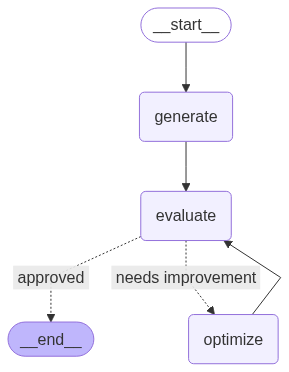

In [83]:
workflow

In [86]:
initial_state = {
    'topic': 'Lionel Messi',
    'iteration': 1,
    'max_iteration': 5
}

workflow.invoke(initial_state)

{'topic': 'Lionel Messi',
 'tweet': "Pigeon just nutmegged a breadcrumb.  Messi's got nothing on this feathered footwork. #PigeonSkills #BirdBall #NextLevel",
 'evaluation': 'approved',
 'feedback': 'The tweet is short, punchy, and original. The comparison to Messi is unexpected and humorous, making it likely to go viral. The hashtags are relevant and well-chosen.  The format is excellent; it avoids the pitfalls of setup-punchline jokes and stays within the character limit. Overall, a solid tweet.',
 'iteration': 2,
 'max_iteration': 5,
 'tweet_history': ['Just saw a pigeon trying to dribble a breadcrumb.  Pretty sure it was practicing its Messi impression.  #GOAT #PigeonMessi #SmallButMighty',
  "Pigeon just nutmegged a breadcrumb.  Messi's got nothing on this feathered footwork. #PigeonSkills #BirdBall #NextLevel"],
 'feedback_history': ["The tweet shows promise with its creative premise of a pigeon attempting basketball-like maneuvers with a breadcrumb. The hashtags add a bit of pla